In [10]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
! cp kaggle.json ~/.kaggle/

In [13]:
! chmod 600 ~/.kaggle/kaggle.json

In [14]:
! kaggle datasets download die9origephit/nike-adidas-and-converse-imaged

nike-adidas-and-converse-imaged.zip: Skipping, found more recently modified local copy (use --force to force download)


In [15]:
! unzip nike-adidas-and-converse-imaged.zip

Archive:  nike-adidas-and-converse-imaged.zip
replace test/adidas/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test/adidas/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace test/adidas/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test/adidas/1.jpg       
  inflating: test/adidas/10.jpg      
  inflating: test/adidas/11.jpg      
  inflating: test/adidas/12.jpg      
  inflating: test/adidas/13.jpg      
  inflating: test/adidas/14.jpg      
  inflating: test/adidas/15.jpg      
  inflating: test/adidas/16.jpg      
  inflating: test/adidas/17.jpg      
  inflating: test/adidas/18.jpg      
  inflating: test/adidas/19.jpg      
  inflating: test/adidas/2.jpg       
  inflating: test/adidas/20.jpg      
  inflating: test/adidas/21.jpg      
  inflating: test/adidas/22.jpg      
  inflating: test/adidas/23.jpg      
  inflating: test/adidas/24.jpg      
  inflating: test/adidas/25.jpg      
  inflating: test/adidas/26.jpg      
  

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K

import os

### Load Data

In [17]:
train_dir = './train'

IMG_SHAPE  = 224
batch_size = 32

In [18]:
train_set = tf.keras.utils.image_dataset_from_directory(
train_dir,
validation_split = 0.2,
seed = 123,
batch_size = batch_size,
image_size =(IMG_SHAPE,IMG_SHAPE),
subset='training')

valid_set = tf.keras.utils.image_dataset_from_directory(
train_dir,
validation_split = 0.2,
seed = 123,
batch_size = batch_size,
image_size =(IMG_SHAPE,IMG_SHAPE),
subset='validation')

Found 711 files belonging to 3 classes.
Using 569 files for training.
Found 711 files belonging to 3 classes.
Using 142 files for validation.


In [19]:
test_dir = './test'
test_set = tf.keras.utils.image_dataset_from_directory(test_dir, shuffle=True,
                                                       seed=123, batch_size=batch_size, image_size=(IMG_SHAPE,IMG_SHAPE))

Found 114 files belonging to 3 classes.


### Explore Data

In [20]:
class_names = train_set.class_names
print(class_names)

['adidas', 'converse', 'nike']


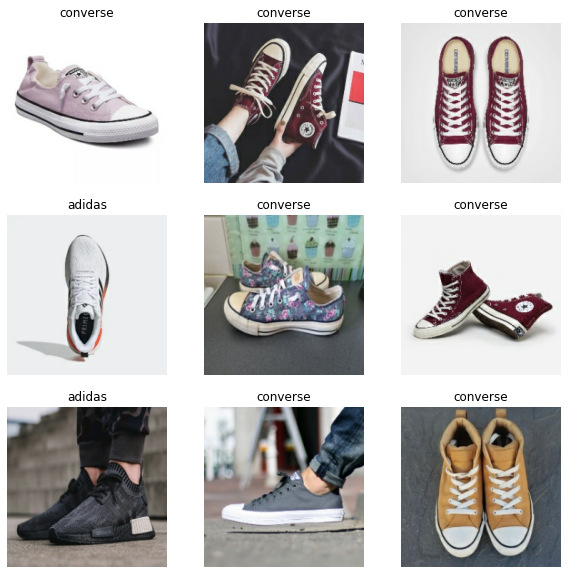

In [21]:
plt.figure(figsize=(10, 10))
for images,labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [22]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [23]:
for val_image_batch, val_labels_batch in valid_set:
  print(val_image_batch.shape)
  print(val_labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [24]:
for test_image_batch, test_labels_batch in test_set:
  print(test_image_batch.shape)
  print(test_labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [25]:
train_dir_adidas = './train/adidas'
train_dir_nike = './train/nike'
train_dir_converse = './train/converse'

#Get total number of training images
print('Total number of training adidas images: ',len(os.listdir(train_dir_adidas)))
print('Total number of training nike images: ',len(os.listdir(train_dir_nike)))
print('Total number of training converse images: ',len(os.listdir(train_dir_converse)))

Total number of training adidas images:  237
Total number of training nike images:  237
Total number of training converse images:  237


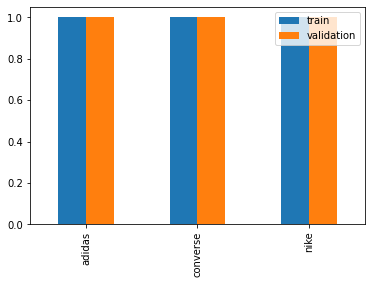

In [26]:
import pandas as pd

_, train_counts = np.unique(train_set, return_counts=True)
_, test_counts = np.unique(valid_set, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'validation': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

### Build the Model

In [27]:
base_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

58900480/58889256 [==============================] - 0s 0us/step


In [28]:
for layer in base_model.layers:
  print(layer.name)
  layer.trainable=False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [29]:
last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

In [30]:
model = tf.keras.Model(base_model.input, x)

In [31]:
model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [33]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20),
    keras.callbacks.ModelCheckpoint(
    filepath='vgg16_standart.h5',
    monitor='val_accuracy',
    save_best_only=True)
]

In [34]:
history = model.fit(train_set, epochs = 80, validation_data=valid_set, callbacks= callbacks_list, batch_size = batch_size, verbose = 1)

Epoch 1/80
18/18 [==============================] - 22s 477ms/step - loss: 49.1673 - accuracy: 0.4148 - val_loss: 20.9710 - val_accuracy: 0.5211
Epoch 2/80
18/18 [==============================] - 4s 207ms/step - loss: 16.5667 - accuracy: 0.6397 - val_loss: 8.6815 - val_accuracy: 0.6690
Epoch 3/80
18/18 [==============================] - 4s 205ms/step - loss: 10.7049 - accuracy: 0.7065 - val_loss: 6.0478 - val_accuracy: 0.7324
Epoch 4/80
18/18 [==============================] - 4s 206ms/step - loss: 5.9823 - accuracy: 0.7627 - val_loss: 6.2817 - val_accuracy: 0.7535
Epoch 5/80
18/18 [==============================] - 4s 199ms/step - loss: 3.4187 - accuracy: 0.8155 - val_loss: 4.1991 - val_accuracy: 0.7535
Epoch 6/80
18/18 [==============================] - 4s 208ms/step - loss: 2.1691 - accuracy: 0.8541 - val_loss: 3.5552 - val_accuracy: 0.7817
Epoch 7/80
18/18 [==============================] - 4s 218ms/step - loss: 2.0314 - accuracy: 0.8366 - val_loss: 2.8418 - val_accuracy: 0.7958
E

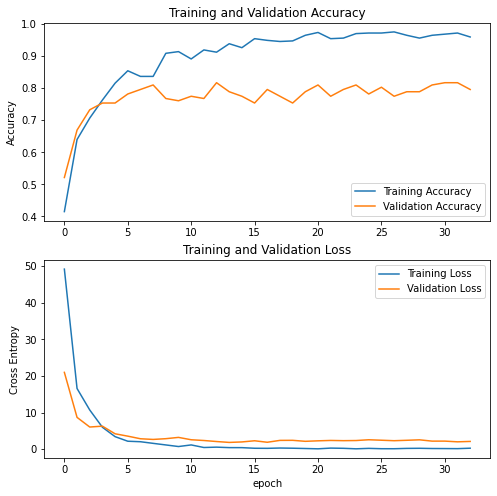

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Train the Model

In [36]:
initial_epochs = 30

loss0, accuracy0 = model.evaluate(test_set)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

4/4 [==============================] - 3s 780ms/step - loss: 1.3450 - accuracy: 0.8509
initial loss: 1.34
initial accuracy: 0.85


### Fine-tunning

In [37]:
model.trainable = True

In [38]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  23


In [39]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [41]:
fine_tune_epochs = 30
history_fine = model.fit(train_set,
                  validation_data=valid_set, 
                  epochs=fine_tune_epochs,
                  callbacks= callbacks_list)

Epoch 1/30
18/18 [==============================] - 5s 218ms/step - loss: 0.1767 - accuracy: 0.9631 - val_loss: 2.1137 - val_accuracy: 0.7958
Epoch 2/30
18/18 [==============================] - 4s 211ms/step - loss: 0.1796 - accuracy: 0.9684 - val_loss: 2.1137 - val_accuracy: 0.7958
Epoch 3/30
18/18 [==============================] - 4s 212ms/step - loss: 0.2003 - accuracy: 0.9666 - val_loss: 2.1137 - val_accuracy: 0.7958
Epoch 4/30
18/18 [==============================] - 4s 214ms/step - loss: 0.2412 - accuracy: 0.9596 - val_loss: 2.1137 - val_accuracy: 0.7958
Epoch 5/30
18/18 [==============================] - 4s 213ms/step - loss: 0.1747 - accuracy: 0.9631 - val_loss: 2.1137 - val_accuracy: 0.7958
Epoch 6/30
18/18 [==============================] - 4s 212ms/step - loss: 0.1151 - accuracy: 0.9736 - val_loss: 2.1137 - val_accuracy: 0.7958
Epoch 7/30
18/18 [==============================] - 4s 212ms/step - loss: 0.1754 - accuracy: 0.9596 - val_loss: 2.1137 - val_accuracy: 0.7958
Epoch 

In [42]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

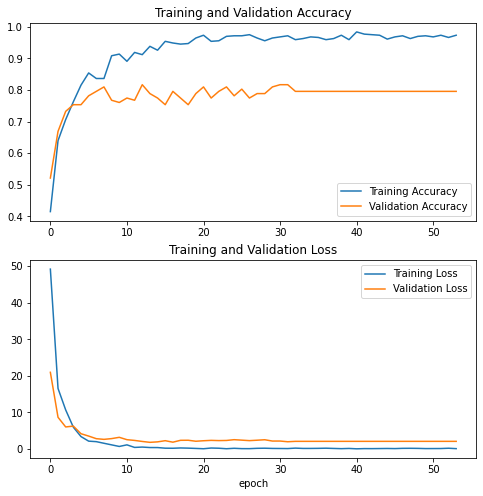

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [46]:
print("We got an accuracy of {:.2f}%".format(model.evaluate(test_set)[1]*100))

4/4 [==============================] - 1s 152ms/step - loss: 1.3450 - accuracy: 0.8509
We got an accuracy of 85.09%


In [47]:
image_batch, label_batch = test_set.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
y_pred = []
predictions = tf.nn.softmax(predictions)

print('Labels:\n', label_batch)

for i in range(0, len(label_batch)):
    y_pred.append(np.argmax(predictions[i]))
    
print('Predictions:\n',np.array(y_pred))

Labels:
 [0 2 1 0 2 0 0 2 1 1 0 1 2 1 2 1 2 2 0 2 1 0 0 0 0 2 0 1 1 0 1 0]
Predictions:
 [2 2 1 0 2 0 0 2 1 1 0 2 2 2 2 1 2 1 0 2 2 0 0 0 0 2 0 1 1 0 1 0]


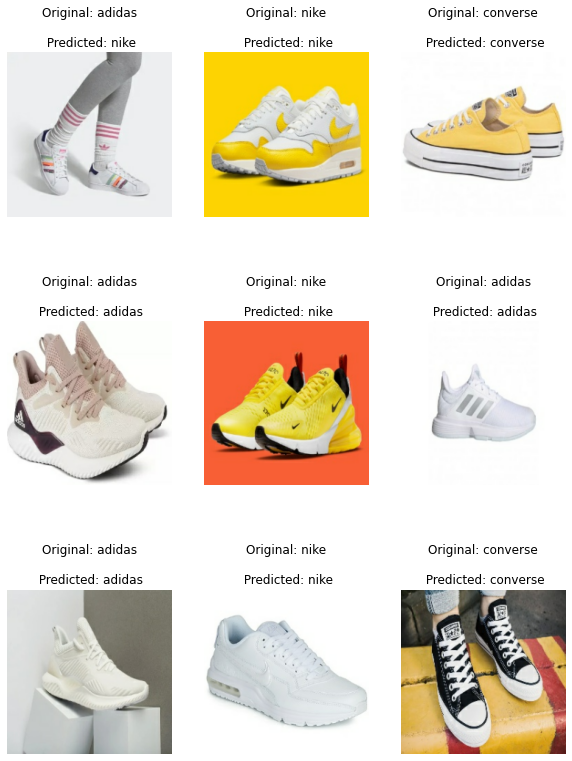

In [48]:
plt.figure(figsize=(10, 14))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Original: {class_names[label_batch[i]]}\n\n Predicted: {class_names[y_pred[i]]}")
    plt.axis("off")

### Confusion Matrix

In [49]:
from numpy import argmax
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

pred = model.predict(test_set)
predictions = argmax(pred, axis=1) # return to label

Labels:
 [0 2 1 0 2 0 0 2 1 1 0 1 2 1 2 1 2 2 0 2 1 0 0 0 0 2 0 1 1 0 1 0]
Predictions:
 [2 2 1 0 2 0 0 2 1 1 0 2 2 2 2 1 2 1 0 2 2 0 0 0 0 2 0 1 1 0 1 0]


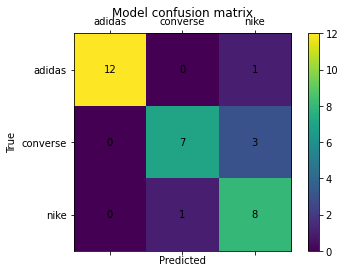

Accuracy : 84.38%
              precision    recall  f1-score   support

      adidas       1.00      0.92      0.96        13
    converse       0.88      0.70      0.78        10
        nike       0.67      0.89      0.76         9

    accuracy                           0.84        32
   macro avg       0.85      0.84      0.83        32
weighted avg       0.87      0.84      0.85        32



In [50]:
from numpy import argmax
from sklearn.metrics import confusion_matrix, accuracy_score

#pred = model.predict(image_batch)
y_pred = []
predictions = model.predict_on_batch(image_batch)
predictions = tf.nn.softmax(predictions)

print('Labels:\n', label_batch)

for i in range(0, len(label_batch)):
    y_pred.append(np.argmax(predictions[i]))
    
print('Predictions:\n',np.array(y_pred))

cm = confusion_matrix(label_batch, y_pred)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Model confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + class_names)
ax.set_yticklabels([''] + class_names)

for i in range(3):
    for j in range(3):
        ax.text(i, j, cm[j, i], va='center', ha='center')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


accuracy = accuracy_score(label_batch, y_pred)
print("Accuracy : %.2f%%" % (accuracy*100.0))

print(classification_report(label_batch, y_pred, target_names=class_names))